In [1]:
torch.setdefaulttensortype('torch.FloatTensor')

### Load Kitti dataset

In [2]:
require 'paths'
require 'image'

relative = '../Datasets/Kitti/data_road/'
labels = torch.load(relative .. 'training/labels.t7')
images = torch.FloatTensor(289, 3, 270, 896)
-- labels = torch.ByteTensor(289, 270, 896)

collectgarbage()

filenames = {}
for file in paths.files(relative .. 'training/image_2/') do
    if file:byte() ~= 46 then
        table.insert(filenames, file)
    end
end

table.sort(filenames)

for id, file in ipairs(filenames) do
    local img = image.load(relative .. 'training/image_2/' .. file)
    images[id]:copy(image.scale(img, 896, 270, 'bicubic'))
--     
--     local lbl = image.load(relative .. 'training/gt_image_2/' .. file:gsub('_', '_road_'))
--     labels[id]:copy(image.scale(lbl:sum(1), 896, 270, 'simple'))
end

-- labels[labels:eq(0)] = 1

mean = {}
std = {}

for channel = 1,3 do
    mean[channel] = images[{{}, channel, {}, {}}]:mean()
    images[{{}, channel, {}, {}}]:add(-mean[channel])
    
    std[channel] = images[{{}, channel, {}, {}}]:std()
    images[{{}, channel, {}, {}}]:div(std[channel])
end

collectgarbage()

### Render labels for displaying

In [3]:
function renderLabels(labels, img, blendCoeff)
    local LUT = {
        [0] = {0.0, 1.0, 0.0}, -- void
        [1] = {0.0, 0.0, 0.0}, -- no road
        [2] = {1.0, 0.0, 0.0}, -- road
    }
    
    local retval = torch.FloatTensor(3, labels:size(1), labels:size(2))
    for i = 1,labels:size(1) do
        for j = 1,labels:size(2) do
            for k, color in ipairs(LUT[labels[{i,j}]]) do
                retval[{k,i,j}] = color
            end
        end
    end
    
    if img then
        local labelsBlendCoeff = blendCoeff or 0.5
        retval:mul(labelsBlendCoeff)
        
        img = img:clone()
        img:add(-img:min())
        img:div(img:max())
        img:mul(1 - labelsBlendCoeff)
        retval:add(img)
    end
    
    return retval
end

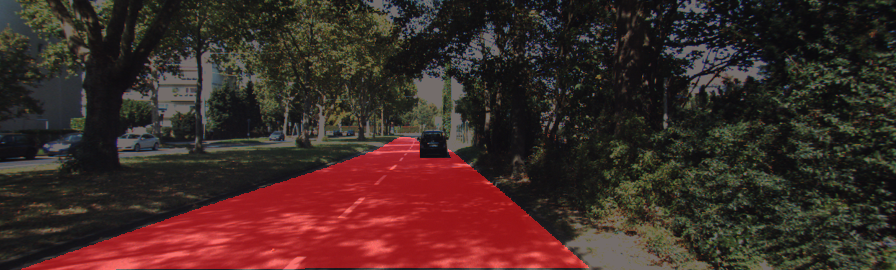

In [4]:
-- example blending
local k = 10
itorch.image(renderLabels(labels[k], images[k]))
-- itorch.image(comparePredictions(images[k], labels[k], predict(net, images[k])))

In [5]:
require 'nn'

function jitterScale(img, labelsMat)
    local h, w = img:size(2), img:size(3)
    
--     local scaleDiffFactor = math.random() * 0.09 - 0.045 -- originally +/- 10%
    local scaleDiffFactor = -math.random() * 0.05
    local heightDiff = math.floor(img:size(2) * scaleDiffFactor)
    local widthDiff = math.floor(img:size(3) * scaleDiffFactor)
    local padder = 
        nn.SpatialZeroPadding(widthDiff, widthDiff, heightDiff, heightDiff)

    local imgScaled = image.scale(padder:forward(img), w, h, 'bilinear')
    local labelsMatScaled = 
        image.scale(
            padder:forward(labelsMat:view(1, h, w)), w, h, 'simple')

    return imgScaled, labelsMatScaled:view(h, w)
end

function jitter(img, labelsMat, flip)
    local imgFlipped, labelsMatFlipped

    if flip then
        imgFlipped = image.flip(img, 3)
        labelsMatFlipped = image.flip(labelsMat, 2)
    end

    local angle = (math.random() - 0.5) * (math.pi / 180 * 9)
    local imgRotated = imgFlipped or img --image.rotate(imgFlipped or img, angle, 'bilinear')
    local labelsMatRotated = labelsMatFlipped or labelsMat
        --image.rotate(labelsMatFlipped or labelsMat, angle, 'simple')

    return jitterScale(imgRotated, labelsMatRotated)
end

In [6]:
CUDA = true

In [7]:
Integral = nil
IntegralSmartNorm = nil
debug.getregistry()['Integral'] = nil 
debug.getregistry()['IntegralSmartNorm'] = nil 
package.loaded['Integral-c'] = nil
package.loaded['Integral-c-multi'] = nil
package.loaded['Integral-jit'] = nil
package.loaded['Integral-jit-multi'] = nil
package.loaded['Integral-cuda-multi'] = nil
package.loaded['IntegralSmartNorm'] = nil

require 'IntegralSmartNorm'

In [8]:
if CUDA then
    require 'cunn'
end

net = torch.load('Kitti 3layers no1px/net.t7')
losses = torch.load('Kitti 3layers no1px/loss-history.t7')

ints = net:findModules('IntegralSmartNorm')
for i = 1,#ints do
    ints[i].maxX = 210
    ints[i].maxY = 540
end

In [12]:
local h, w = 270,896

net = nn.Sequential()

convPlusInt = nn.Concat(1)
convPlusInt:add(IntegralSmartNorm(20, h, w))
convPlusInt:add(nn.SpatialConvolution(3, 18, 5,5, 1,1, 2,2))
net:add(convPlusInt) -- 3 -> 78

net:add(nn.LeakyReLU(0.03))
net:add(nn.SpatialConvolutionMM(78, 8, 1,1,1,1)) -- 78 -> 8

convPlusInt2 = nn.Concat(1)
convPlusInt2:add(IntegralSmartNorm(12, h, w))
convPlusInt2:add(nn.SpatialConvolution(8, 12, 3,3, 1,1, 1,1))
net:add(convPlusInt2) -- 8 -> 108

net:add(nn.LeakyReLU(0.03))
net:add(nn.SpatialConvolution(108, 10, 1,1,1,1)) -- 108 -> 10

convPlusInt3 = nn.Concat(1)
convPlusInt3:add(IntegralSmartNorm(10, h, w))
convPlusInt3:add(nn.SpatialConvolution(10, 12, 3,3, 1,1, 1,1))
net:add(convPlusInt3) -- 10 -> 112

net:add(nn.LeakyReLU(0.03))
net:add(nn.SpatialConvolution(112, 2, 1,1,1,1)) -- 112 -> 2

net:add(nn.Reshape(2, h*w))
net:add(nn.Transpose({2, 1}))

ints = net:findModules('IntegralSmartNorm')
for i = 1,#ints do
    ints[i].maxX = 210
    ints[i].maxY = 540
end

if CUDA then
    require 'cunn'
    net:cuda()
end

collectgarbage()

In [9]:
params, gradParams = net:parameters()

In [10]:
local function calcClassWeights(labels)
    local counts = {}
    labels:apply(function(x) counts[x] = (counts[x] or 0) + 1 end)
    counts[0] = nil

    local sum = 0
    for k, v in pairs(counts) do
        sum = sum + v
    end

    for k, v in pairs(counts) do
        counts[k] = sum / v -- inverse frequency
    end

    local classWeights = torch.Tensor(counts)
    classWeights:div(classWeights:mean())
    return classWeights, counts
end

classWeights, classCounts = calcClassWeights(labels)
criterion = nn.CrossEntropyCriterion(classWeights):type(net:type())

In [24]:
require 'optim'

datasetIdx = 1

optimStates = {}

for i = 1,#params do
    local lr = 0.1e-3
    if i <= 4 or (i >= 9 and i <= 12) or (i >= 17 and i <= 20) then
        lr = lr * 350
    end
    
    optimStates[i] = {
        learningRate = lr,
--         learningRateDecay = 0.99955
    }
end

In [12]:
package.loaded.WindowDebugger = nil
debug.getregistry().WindowDebugger = nil
WindowDebugger = nil

require 'WindowDebugger'

windowDebugger_1 = WindowDebugger()
windowDebugger_2 = WindowDebugger()
windowDebugger_3 = WindowDebugger()

In [17]:
local filenames = {}
for file in paths.files(relative .. 'testing/image_2/') do
    if file:byte() ~= 46 then
        table.insert(filenames, file)
    end
end

table.sort(filenames)

local avgTime = 0
local numRuns = 0

local i = 1
while i <= #filenames do
    local img = image.scale(image.load(relative .. 'testing/image_2/' .. filenames[i]), 896, 270, 'bicubic')
    
    local imgForNet = img:cuda()
    for channel = 1,3 do
        imgForNet[channel]:add(-mean[channel])
        imgForNet[channel]:div(std[channel])
    end
    
    timer = torch.Timer()
    local prediction = predict(net, imgForNet)
    avgTime = avgTime + timer:time().real
    numRuns = numRuns + 1
    
    local output = torch.ones(3, img:size(2)*2 + 4, img:size(3))
    
    output[{{}, {1, img:size(2)}, {}}]:copy(img)
    output[{{}, {img:size(2)+3, img:size(2)*2+2}, {}}]:copy(renderLabels(prediction, img))
    
    image.save(outputDir .. 'Images (test)/' .. '_' .. filenames[i], output)
    
    i = i + 6
end

collectgarbage()
print('Average inference time: ' .. (avgTime / numRuns * 1e3) .. ' ms')

[string "local filenames = {}..."]:24: attempt to call global 'predict' (a nil value)
stack traceback:
	[string "local filenames = {}..."]:24: in main chunk
	[C]: in function 'xpcall'
	/home/user/torch/install/share/lua/5.1/itorch/main.lua:209: in function </home/user/torch/install/share/lua/5.1/itorch/main.lua:173>
	/home/user/torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	/home/user/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	/home/user/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	/home/user/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/home/user/torch/install/share/lua/5.1/itorch/main.lua:381: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x00406670: 

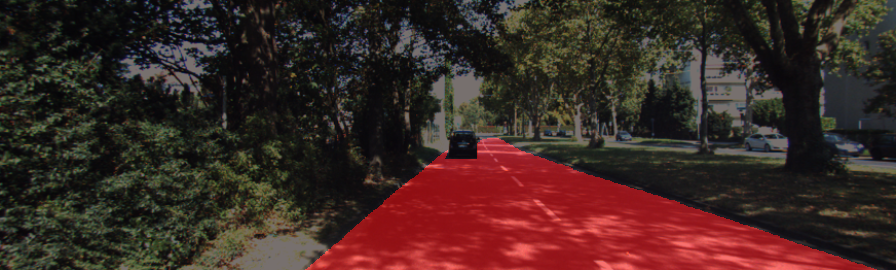

In [13]:
k = 10
img, lab = jitter(images[k], labels[k], torch.random() % 2 == 0)
itorch.image(renderLabels(lab, img))

In [14]:
require 'gnuplot'

function plotLosses(losses)
    gnuplot.figure(3)
    gnuplot.plot(torch.Tensor(losses), '-')
    gnuplot.axis{1, #losses, 0.02, 0.2}
    gnuplot.xlabel('Iteration')
    gnuplot.ylabel('Loss')
end

In [15]:
outputDir = 'Kitti 3layers no1px/'
os.execute('mkdir "' .. outputDir .. 'Images" -p')

In [15]:
losses = {}

In [16]:
function predict(net, example)
    local pred = net:forward(example:type(net:type()))
    return select(2, pred:view(example:size(2), example:size(3), 2):max(3)):squeeze():float()
end

function comparePredictions(img, labels, prediction, omitOriginal)
    img = img:clone():float()
    
    img:add(-img:min())
    img:div(img:max())
    
    local retval
    
    if omitOriginal then
        retval = torch.ones(3, img:size(2)*2 + 4, img:size(3))

        retval[{{}, {1, img:size(2)}, {}}]:copy(renderLabels(labels, img))
        retval[{{}, {img:size(2)+3, img:size(2)*2+2}, {}}]:copy(renderLabels(prediction, img))
    else
        retval = torch.ones(3, img:size(2)*3 + 4, img:size(3))
        retval[{{}, {1, img:size(2)}, {}}]:copy(img)
        retval[{{}, {img:size(2)+3, img:size(2)*2+2}, {}}]:copy(renderLabels(labels, img))
        retval[{{}, {img:size(2)*2+5, retval:size(2)}, {}}]:copy(renderLabels(prediction, img))
    end
    
    return retval
end

In [17]:
evaluationIdx = {
    1, 14, 27, 40, 53, 66, 79, 92, 105, 118, 131, 144, 157, 
    170, 183, 196, 209, 222, 235, 248, 261, 274, 287
}

table.sort(evaluationIdx)

In [18]:
function evaluate(net, images, labels, indices, outPath)
    local losses = {}
    local avgLoss = 0
    
    for k,idx in ipairs(indices) do
        local input = images[idx]:type(net:type())
        local outputs = net:forward(input)
        local target = labels[idx]:clone()
        
        if outPath then
            image.savePNG(
                outPath .. string.format('/%03d.png', idx), 
                comparePredictions(input, target, 
                    select(2, outputs:view(target:size(1), target:size(2), 2):max(3)):squeeze():float()))
        end
        
        target = target:view(target:nElement())

--         for i = 1,target:nElement() do
--             if target[i] == 0 then
--                 target[i] = 3
--                 outputs[i]:zero()
--                 outputs[{i,3}] = 1e4
--             end
--         end

        target = target:type(criterion.lsm:type())

        local loss = criterion:forward(outputs, target)
        losses[k] = loss
        avgLoss = avgLoss + loss
    end
    
    collectgarbage()
    
    avgLoss = avgLoss / #indices
    
    return avgLoss, losses
end

function evaluateMaxF1(net, images, labels, indices, outPath)
    local maxF1, maxF1Threshold = -1, -1
    
    local outputs = {}
    local targets = {}
    for k,idx in ipairs(indices) do
        local input = images[idx]:type(net:type())
        outputs[k] = net:forward(input):float()
        targets[k] = labels[idx]:clone():add(-1)
    end

    local tauMax = 30
    for tau = 1,tauMax-1 do
        local threshold = tau / tauMax
        local tp, fp, fn = 0, 0, 0
    
        for k,idx in ipairs(indices) do
            local target = targets[k]:view(targets[k]:nElement())
            local predictions = outputs[k][{{}, 2}]:gt(threshold)
            
            tp = tp + torch.cmul(target, predictions):sum()
            fp = fp + torch.cmul(target:eq(0), predictions):sum()
            fn = fn + torch.cmul(target, predictions:eq(0)):sum()
        end
        
        local precision = tp / (tp + fp)
        local recall = tp / (tp + fn)
        local f1 = 2 * precision * recall / (precision + recall)
        
        if f1 > maxF1 then
            maxF1 = f1
            maxF1Threshold = threshold
        end
    end

    if outPath then
        for k,idx in ipairs(indices) do
            local target = targets[k]
            target:add(1)
            local output = outputs[k]
            
            image.savePNG(
                outPath .. string.format('/%03d.png', idx), 
                comparePredictions(
                    images[idx], 
                    target, 
--                     output[{{}, 2}]:gt(maxF1Threshold):add(1):view(target:size(1), target:size(2))))
                    select(2, output:view(target:size(1), target:size(2), 2):max(3)):squeeze():float()))
        end
    end
    
    collectgarbage()
    
    return maxF1, maxF1Threshold
end

In [20]:
plotLosses(losses)

In [26]:
batchSize = 3
shuffleEvery = math.ceil(images:size(1) / batchSize) -- shuffle data every `shuffleEvery` iterations
outputFreq = 6 -- how often to output loss to `losses` table and to redraw loss graph
imgOutputFreq = 24 -- save validation predictions as images every `outputFreq*imgOutputFreq` iterations
saveFreq = 20 -- how often to save `net` and `windowDebugger`s

function randomShuffle(t)
  for i = 1,#t do
    local j = math.random(i, #t)
    t[i], t[j] = t[j], t[i]
  end
end

idx = {}
for i = 1,images:size(1) do
    idx[i] = i
end

local avgLoss = 0

for iter = 1,1441 do
    
    if (iter-1) % shuffleEvery == 0 then
        randomShuffle(idx)
        print('Epoch ' .. ((iter-1) / shuffleEvery))
    end
    
    windowDebugger_1:add(net:get(1):get(1))
    windowDebugger_2:add(net:get(4):get(1))
    windowDebugger_3:add(net:get(7):get(1))
    
    local batchLoss = 0 -- at current minibatch
    
    -- forward + backward
    do
        net:zeroGradParameters()

        for k = 1,batchSize do

            local input, target = jitter(
                images[idx[datasetIdx]], 
                labels[idx[datasetIdx]], 
                torch.random() % 2 == 0)
            
            target = target:view(target:nElement())

            input = input:type(net:type())
            local outputs = net:forward(input)

--             for i = 1,target:nElement() do
--                 if target[i] == 0 then
--                     target[i] = 3
--                     outputs[i]:zero()
--                     outputs[{i,3}] = 1e4
--                 end
--             end
            
            target = target:type(net:type())

            batchLoss = batchLoss + criterion:forward(outputs, target)
            local dLoss_dOutputs = criterion:backward(outputs, target)
            net:backward(input, dLoss_dOutputs, 1/batchSize) -- accumulate gradients
            
            datasetIdx = datasetIdx % labels:size(1) + 1
        end
        
        batchLoss = batchLoss / batchSize
    end
    
    avgLoss = avgLoss + batchLoss
    
    -- optimization step
    for i = 1,#params do
        local feval = function(x)
            return batchLoss, gradParams[i]
        end
        
        optim.adam(feval, params[i], optimStates[i])
    end

    collectgarbage()
    
    if ((iter-1) % (outputFreq*imgOutputFreq) == 0) then
        local timer = torch.Timer()
        local maxF1, maxF1threshold = 
            evaluateMaxF1(net, images, labels, evaluationIdx, outputDir .. 'Images/')
        local time = timer:time().real
        print(string.format(
                'Max F1 = %.2f%% at tau = %.3f, time %.2f seconds', 
                maxF1 * 100, maxF1threshold, time))
    end

    if (iter-1) % outputFreq == 0 then
        losses[#losses+1] = 
            evaluate(net, images, labels, evaluationIdx)
        
        -- losses[#losses+1] = avgLoss / outputFreq
        
        plotLosses(losses)
    end
    
    if (iter-1) % saveFreq == 0 then
        net:clearState()
        torch.save(outputDir .. 'net.t7', net)
        torch.save(outputDir .. 'loss-history.t7', losses)
        windowDebugger_1:exportVideo(outputDir .. 'int-layer-1.avi')
        windowDebugger_2:exportVideo(outputDir .. 'int-layer-2.avi')
        windowDebugger_3:exportVideo(outputDir .. 'int-layer-3.avi')
    end
    
    if iter % 4 == 0 then
        print(
            'Iteration ' .. iter ..
            ', loss = ' .. (avgLoss / 4 or -1) .. ', ' .. os.date()
        )
        avgLoss = 0
    end
end

Epoch 0	


Max F1 = 88.10% at tau = 0.833, time 41.00 seconds	


Iteration 4, loss = 0.094099033779154, Sun Apr 16 23:31:02 2017	


Iteration 8, loss = 0.092154727627834, Sun Apr 16 23:31:38 2017	


Iteration 12, loss = 0.091091462178156, Sun Apr 16 23:32:03 2017	


Iteration 16, loss = 0.10384960534672, Sun Apr 16 23:32:37 2017	


Iteration 20, loss = 0.11857825051993, Sun Apr 16 23:33:12 2017	


Iteration 24, loss = 0.079104868074258, Sun Apr 16 23:33:59 2017	


Iteration 28, loss = 0.10098612277458, Sun Apr 16 23:34:36 2017	


Iteration 32, loss = 0.0765367547671, Sun Apr 16 23:35:10 2017	


Iteration 36, loss = 0.08167992780606, Sun Apr 16 23:35:35 2017	


Iteration 40, loss = 0.080517981822292, Sun Apr 16 23:36:13 2017	


Iteration 44, loss = 0.082805970994135, Sun Apr 16 23:37:19 2017	


Iteration 48, loss = 0.10187433877339, Sun Apr 16 23:37:45 2017	


Iteration 52, loss = 0.097930341959, Sun Apr 16 23:38:23 2017	


Iteration 56, loss = 0.0865127419432, Sun Apr 16 23:39:01 2017	


Iteration 60, loss = 0.091986955997224, Sun Apr 16 23:39:28 2017	


Iteration 64, loss = 0.060815108629564, Sun Apr 16 23:40:36 2017	


Iteration 68, loss = 0.10950639750808, Sun Apr 16 23:41:14 2017	


Iteration 72, loss = 0.081925986179461, Sun Apr 16 23:41:42 2017	


Iteration 76, loss = 0.084659680724144, Sun Apr 16 23:42:23 2017	


Iteration 80, loss = 0.11027714811886, Sun Apr 16 23:43:04 2017	


Iteration 84, loss = 0.081414443906397, Sun Apr 16 23:44:01 2017	


Iteration 88, loss = 0.11971732632567, Sun Apr 16 23:44:40 2017	


Iteration 92, loss = 0.087222413159907, Sun Apr 16 23:45:20 2017	


Iteration 96, loss = 0.11799923485766, Sun Apr 16 23:45:48 2017	


Epoch 1	


Iteration 100, loss = 0.10307278577238, Sun Apr 16 23:46:27 2017	


Iteration 104, loss = 0.082748521429797, Sun Apr 16 23:47:35 2017	


Iteration 108, loss = 0.092115689922745, Sun Apr 16 23:48:04 2017	


Iteration 112, loss = 0.082207815954462, Sun Apr 16 23:48:41 2017	


Iteration 116, loss = 0.088937354274094, Sun Apr 16 23:49:16 2017	


Iteration 120, loss = 0.11693138411889, Sun Apr 16 23:49:40 2017	


Iteration 124, loss = 0.092177886360635, Sun Apr 16 23:50:36 2017	


Iteration 128, loss = 0.10249139601365, Sun Apr 16 23:51:11 2017	


Iteration 132, loss = 0.092365739246209, Sun Apr 16 23:51:36 2017	


Iteration 136, loss = 0.10172606259584, Sun Apr 16 23:52:11 2017	


Iteration 140, loss = 0.073231145118674, Sun Apr 16 23:52:46 2017	


Iteration 144, loss = 0.099887576730301, Sun Apr 16 23:53:35 2017	


Max F1 = 88.13% at tau = 0.767, time 43.06 seconds	


Iteration 148, loss = 0.088964669809987, Sun Apr 16 23:54:55 2017	


Iteration 152, loss = 0.10341811086982, Sun Apr 16 23:55:33 2017	


Iteration 156, loss = 0.10279245472824, Sun Apr 16 23:55:59 2017	


Iteration 160, loss = 0.091861999748896, Sun Apr 16 23:56:37 2017	


Iteration 164, loss = 0.072615128786614, Sun Apr 16 23:57:39 2017	


Iteration 168, loss = 0.1026616540427, Sun Apr 16 23:58:05 2017	


Iteration 172, loss = 0.082367669325322, Sun Apr 16 23:58:41 2017	


Iteration 176, loss = 0.097845334249238, Sun Apr 16 23:59:17 2017	


Iteration 180, loss = 0.093167659981797, Sun Apr 16 23:59:42 2017	


Iteration 184, loss = 0.080891391728073, Mon Apr 17 00:00:39 2017	


Iteration 188, loss = 0.079852102945248, Mon Apr 17 00:01:16 2017	


Iteration 192, loss = 0.10372941941023, Mon Apr 17 00:01:41 2017	


Epoch 2	


Iteration 196, loss = 0.08502233447507, Mon Apr 17 00:02:16 2017	


Iteration 200, loss = 0.10123862015704, Mon Apr 17 00:02:52 2017	


Iteration 204, loss = 0.088776080403477, Mon Apr 17 00:03:39 2017	


Iteration 208, loss = 0.094875463750213, Mon Apr 17 00:04:17 2017	


Iteration 212, loss = 0.091076740374168, Mon Apr 17 00:04:53 2017	


Iteration 216, loss = 0.10023908844839, Mon Apr 17 00:05:20 2017	


Iteration 220, loss = 0.087815820239484, Mon Apr 17 00:05:55 2017	


Iteration 224, loss = 0.066594890784472, Mon Apr 17 00:06:59 2017	


Iteration 228, loss = 0.11572766521325, Mon Apr 17 00:07:25 2017	


Iteration 232, loss = 0.11659735751649, Mon Apr 17 00:08:01 2017	


Iteration 236, loss = 0.11918232093255, Mon Apr 17 00:08:37 2017	


Iteration 240, loss = 0.10683187974306, Mon Apr 17 00:09:03 2017	


Iteration 244, loss = 0.067417604227861, Mon Apr 17 00:10:13 2017	


Iteration 248, loss = 0.080800078654041, Mon Apr 17 00:10:50 2017	


Iteration 252, loss = 0.077723915378253, Mon Apr 17 00:11:19 2017	


Iteration 256, loss = 0.10959564816828, Mon Apr 17 00:11:59 2017	


Iteration 260, loss = 0.10013804553698, Mon Apr 17 00:12:37 2017	


Iteration 264, loss = 0.10367510436724, Mon Apr 17 00:13:46 2017	


Iteration 268, loss = 0.091137168308099, Mon Apr 17 00:14:26 2017	


Iteration 272, loss = 0.079485293788215, Mon Apr 17 00:15:06 2017	


Iteration 276, loss = 0.096092460366587, Mon Apr 17 00:15:35 2017	


Iteration 280, loss = 0.09662003411601, Mon Apr 17 00:16:14 2017	


Iteration 284, loss = 0.083099362440407, Mon Apr 17 00:17:32 2017	


Iteration 288, loss = 0.068099114267776, Mon Apr 17 00:18:08 2017	


Max F1 = 88.37% at tau = 0.800, time 53.15 seconds	


Epoch 3	


Iteration 292, loss = 0.08578559026743, Mon Apr 17 00:19:45 2017	


Iteration 296, loss = 0.10413427387054, Mon Apr 17 00:20:26 2017	


Iteration 300, loss = 0.11601113853976, Mon Apr 17 00:20:56 2017	


Iteration 304, loss = 0.11677633350094, Mon Apr 17 00:22:14 2017	


Iteration 308, loss = 0.085528416248659, Mon Apr 17 00:22:54 2017	


Iteration 312, loss = 0.079930954612792, Mon Apr 17 00:23:24 2017	


Iteration 316, loss = 0.084792155927668, Mon Apr 17 00:24:04 2017	


Iteration 320, loss = 0.0947733996436, Mon Apr 17 00:24:44 2017	


Iteration 324, loss = 0.10120513321211, Mon Apr 17 00:25:52 2017	


Iteration 328, loss = 0.10049125971273, Mon Apr 17 00:26:33 2017	


Iteration 332, loss = 0.10463173920289, Mon Apr 17 00:27:13 2017	


Iteration 336, loss = 0.075751982474079, Mon Apr 17 00:27:44 2017	


Iteration 340, loss = 0.10123528260738, Mon Apr 17 00:28:26 2017	


Iteration 344, loss = 0.061449766003837, Mon Apr 17 00:29:46 2017	


Iteration 348, loss = 0.072833086208751, Mon Apr 17 00:30:15 2017	


Iteration 352, loss = 0.089899289266517, Mon Apr 17 00:30:55 2017	


Iteration 356, loss = 0.11573066500326, Mon Apr 17 00:31:36 2017	


Iteration 360, loss = 0.075208489783108, Mon Apr 17 00:32:06 2017	


Iteration 364, loss = 0.1012236851578, Mon Apr 17 00:33:25 2017	


Iteration 368, loss = 0.07639158066983, Mon Apr 17 00:34:07 2017	


Iteration 372, loss = 0.078545306964467, Mon Apr 17 00:34:37 2017	


Iteration 376, loss = 0.11522184560696, Mon Apr 17 00:35:17 2017	


Iteration 380, loss = 0.092149287307014, Mon Apr 17 00:35:58 2017	


Iteration 384, loss = 0.083683714348202, Mon Apr 17 00:37:08 2017	


Iteration 388, loss = 0.090852186704675, Mon Apr 17 00:37:48 2017	
Epoch 4	


Iteration 392, loss = 0.077480192140987, Mon Apr 17 00:38:28 2017	


Iteration 396, loss = 0.10320676816627, Mon Apr 17 00:38:57 2017	


Iteration 400, loss = 0.08692909621944, Mon Apr 17 00:39:39 2017	


Iteration 404, loss = 0.080287849530578, Mon Apr 17 00:40:59 2017	


Iteration 408, loss = 0.10009313250581, Mon Apr 17 00:41:30 2017	


Iteration 412, loss = 0.11117394516865, Mon Apr 17 00:42:10 2017	


Iteration 416, loss = 0.089533551052834, Mon Apr 17 00:42:51 2017	


Iteration 420, loss = 0.11322561635946, Mon Apr 17 00:43:21 2017	


Iteration 424, loss = 0.098566115523378, Mon Apr 17 00:44:42 2017	


Iteration 428, loss = 0.085715560242534, Mon Apr 17 00:45:23 2017	


Iteration 432, loss = 0.097774893511087, Mon Apr 17 00:45:53 2017	


Max F1 = 88.23% at tau = 0.800, time 54.06 seconds	


Iteration 436, loss = 0.085196822105596, Mon Apr 17 00:47:28 2017	


Iteration 440, loss = 0.072984978090972, Mon Apr 17 00:48:10 2017	


Iteration 444, loss = 0.090847549494356, Mon Apr 17 00:49:21 2017	


Iteration 448, loss = 0.091232266277075, Mon Apr 17 00:50:02 2017	


Iteration 452, loss = 0.070552071246008, Mon Apr 17 00:50:42 2017	


Iteration 456, loss = 0.086354551526407, Mon Apr 17 00:51:13 2017	


Iteration 460, loss = 0.096431024372578, Mon Apr 17 00:51:55 2017	


Iteration 464, loss = 0.12381554767489, Mon Apr 17 00:53:15 2017	


Iteration 468, loss = 0.09542329950879, Mon Apr 17 00:53:44 2017	


Iteration 472, loss = 0.081023868173361, Mon Apr 17 00:54:25 2017	


Iteration 476, loss = 0.11941603664309, Mon Apr 17 00:55:06 2017	


Iteration 480, loss = 0.089448822662234, Mon Apr 17 00:55:37 2017	


Iteration 484, loss = 0.099283593551566, Mon Apr 17 00:56:57 2017	


Epoch 5	


Iteration 488, loss = 0.091607935959473, Mon Apr 17 00:57:38 2017	


Iteration 492, loss = 0.09963407414034, Mon Apr 17 00:58:09 2017	


Iteration 496, loss = 0.11898470887293, Mon Apr 17 00:58:50 2017	


Iteration 500, loss = 0.11199948222687, Mon Apr 17 00:59:31 2017	


Iteration 504, loss = 0.068848145970454, Mon Apr 17 01:00:41 2017	


Iteration 508, loss = 0.079359309592595, Mon Apr 17 01:01:23 2017	


Iteration 512, loss = 0.1092107516403, Mon Apr 17 01:02:04 2017	


Iteration 516, loss = 0.089278925520678, Mon Apr 17 01:02:35 2017	


Iteration 520, loss = 0.087510045307378, Mon Apr 17 01:03:16 2017	


Iteration 524, loss = 0.095832881517708, Mon Apr 17 01:04:39 2017	


Iteration 528, loss = 0.10839600147059, Mon Apr 17 01:05:09 2017	


Iteration 532, loss = 0.093501802068204, Mon Apr 17 01:05:51 2017	


Iteration 536, loss = 0.11055033172791, Mon Apr 17 01:06:32 2017	


Iteration 540, loss = 0.078977876342833, Mon Apr 17 01:07:03 2017	


Iteration 544, loss = 0.075746342850228, Mon Apr 17 01:08:27 2017	


Iteration 548, loss = 0.11627174603442, Mon Apr 17 01:09:09 2017	


Iteration 552, loss = 0.10521816182882, Mon Apr 17 01:09:40 2017	


Iteration 556, loss = 0.073915917892009, Mon Apr 17 01:10:21 2017	


Iteration 560, loss = 0.092935049285491, Mon Apr 17 01:11:03 2017	


Iteration 564, loss = 0.069552767633771, Mon Apr 17 01:12:13 2017	


Iteration 568, loss = 0.083126727181176, Mon Apr 17 01:12:53 2017	


Iteration 572, loss = 0.13217209093273, Mon Apr 17 01:13:35 2017	


Iteration 576, loss = 0.08614786931624, Mon Apr 17 01:14:06 2017	


Max F1 = 87.92% at tau = 0.667, time 55.37 seconds	


Iteration 580, loss = 0.098513815396776, Mon Apr 17 01:15:42 2017	


Epoch 6	


Iteration 584, loss = 0.098890137858689, Mon Apr 17 01:17:08 2017	


Iteration 588, loss = 0.10949161866059, Mon Apr 17 01:17:37 2017	


Iteration 592, loss = 0.072263395724197, Mon Apr 17 01:18:17 2017	


Iteration 596, loss = 0.088933591653282, Mon Apr 17 01:18:58 2017	


Iteration 600, loss = 0.11992841757213, Mon Apr 17 01:19:30 2017	


Iteration 604, loss = 0.080843617208302, Mon Apr 17 01:20:51 2017	


Iteration 608, loss = 0.096162888376663, Mon Apr 17 01:21:33 2017	


Iteration 612, loss = 0.075987596840908, Mon Apr 17 01:22:03 2017	


Iteration 616, loss = 0.096339791702727, Mon Apr 17 01:22:44 2017	


Iteration 620, loss = 0.08048855047673, Mon Apr 17 01:23:25 2017	


Iteration 624, loss = 0.094389795480917, Mon Apr 17 01:24:36 2017	


Iteration 628, loss = 0.097167375807961, Mon Apr 17 01:25:18 2017	


Iteration 632, loss = 0.093540547415614, Mon Apr 17 01:25:59 2017	


Iteration 636, loss = 0.10894457499186, Mon Apr 17 01:26:29 2017	


Iteration 640, loss = 0.10499892391575, Mon Apr 17 01:27:09 2017	


Iteration 644, loss = 0.050434362453719, Mon Apr 17 01:28:31 2017	


Iteration 648, loss = 0.095023940860604, Mon Apr 17 01:29:02 2017	


Iteration 652, loss = 0.08796094932283, Mon Apr 17 01:29:43 2017	


Iteration 656, loss = 0.089434797565142, Mon Apr 17 01:30:24 2017	


Iteration 660, loss = 0.10239120502956, Mon Apr 17 01:30:55 2017	


Iteration 664, loss = 0.090173314015071, Mon Apr 17 01:32:18 2017	


Iteration 668, loss = 0.062338575876007, Mon Apr 17 01:32:58 2017	


Iteration 672, loss = 0.11368040367961, Mon Apr 17 01:33:29 2017	


Iteration 676, loss = 0.13066325290129, Mon Apr 17 01:34:10 2017	


Epoch 7	


Iteration 680, loss = 0.073548519673447, Mon Apr 17 01:34:49 2017	


Iteration 684, loss = 0.09364940226078, Mon Apr 17 01:36:02 2017	


Iteration 688, loss = 0.087220959753419, Mon Apr 17 01:36:43 2017	


Iteration 692, loss = 0.074352230566243, Mon Apr 17 01:37:24 2017	


Iteration 696, loss = 0.08249089634046, Mon Apr 17 01:37:55 2017	


Iteration 700, loss = 0.057546701903145, Mon Apr 17 01:38:36 2017	


Iteration 704, loss = 0.10134238749743, Mon Apr 17 01:40:01 2017	


Iteration 708, loss = 0.11236145735408, Mon Apr 17 01:40:31 2017	


Iteration 712, loss = 0.10384814798211, Mon Apr 17 01:41:13 2017	


Iteration 716, loss = 0.091423854231834, Mon Apr 17 01:41:55 2017	


Iteration 720, loss = 0.091866907663643, Mon Apr 17 01:42:26 2017	


Max F1 = 88.66% at tau = 0.700, time 55.31 seconds	


Iteration 724, loss = 0.093279453925788, Mon Apr 17 01:44:45 2017	


Iteration 728, loss = 0.073528133022288, Mon Apr 17 01:45:26 2017	


Iteration 732, loss = 0.078381731407717, Mon Apr 17 01:45:56 2017	


Iteration 736, loss = 0.10012309687833, Mon Apr 17 01:46:37 2017	


Iteration 740, loss = 0.13566434911142, Mon Apr 17 01:47:18 2017	


Iteration 744, loss = 0.080356024205685, Mon Apr 17 01:48:32 2017	


Iteration 748, loss = 0.12911133281887, Mon Apr 17 01:49:13 2017	


Iteration 752, loss = 0.092148835460345, Mon Apr 17 01:49:53 2017	


Iteration 756, loss = 0.073799748749783, Mon Apr 17 01:50:24 2017	


Iteration 760, loss = 0.092701565784713, Mon Apr 17 01:51:05 2017	


Iteration 764, loss = 0.10666469562178, Mon Apr 17 01:52:30 2017	


Iteration 768, loss = 0.10894430847839, Mon Apr 17 01:53:01 2017	


Iteration 772, loss = 0.076791252940893, Mon Apr 17 01:53:43 2017	


Iteration 776, loss = 0.068278728673855, Mon Apr 17 01:54:24 2017	
Epoch 8	


Iteration 780, loss = 0.09113180777058, Mon Apr 17 01:54:54 2017	


Iteration 784, loss = 0.076571258095404, Mon Apr 17 01:56:20 2017	


Iteration 788, loss = 0.075176933780313, Mon Apr 17 01:57:00 2017	


Iteration 792, loss = 0.092416279173146, Mon Apr 17 01:57:29 2017	


Iteration 796, loss = 0.094207022028665, Mon Apr 17 01:58:10 2017	


Iteration 800, loss = 0.087326185933004, Mon Apr 17 01:58:51 2017	


Iteration 804, loss = 0.12194835425665, Mon Apr 17 02:00:05 2017	


Iteration 808, loss = 0.092828908702359, Mon Apr 17 02:00:46 2017	


Iteration 812, loss = 0.087206864419083, Mon Apr 17 02:01:28 2017	


Iteration 816, loss = 0.091092402736346, Mon Apr 17 02:01:58 2017	


Iteration 820, loss = 0.11589210092401, Mon Apr 17 02:02:39 2017	


Iteration 824, loss = 0.11312152259052, Mon Apr 17 02:04:04 2017	


Iteration 828, loss = 0.073024558601901, Mon Apr 17 02:04:34 2017	


Iteration 832, loss = 0.10161049477756, Mon Apr 17 02:05:15 2017	


Iteration 836, loss = 0.081385606123755, Mon Apr 17 02:05:56 2017	


Iteration 840, loss = 0.088176043316101, Mon Apr 17 02:06:27 2017	


Iteration 844, loss = 0.089454477652907, Mon Apr 17 02:07:54 2017	


Iteration 848, loss = 0.0881647534358, Mon Apr 17 02:08:35 2017	


Iteration 852, loss = 0.090651247339944, Mon Apr 17 02:09:05 2017	


Iteration 856, loss = 0.086911606602371, Mon Apr 17 02:09:47 2017	


Iteration 860, loss = 0.13276010969033, Mon Apr 17 02:10:28 2017	


Iteration 864, loss = 0.099944250192493, Mon Apr 17 02:11:43 2017	


Max F1 = 88.76% at tau = 0.867, time 54.19 seconds	


Iteration 868, loss = 0.073939096803466, Mon Apr 17 02:13:20 2017	


Iteration 872, loss = 0.0935811358504, Mon Apr 17 02:14:01 2017	


Epoch 9	


Iteration 876, loss = 0.09415385282288, Mon Apr 17 02:14:32 2017	


Iteration 880, loss = 0.09418566711247, Mon Apr 17 02:15:12 2017	


Iteration 884, loss = 0.084415592408429, Mon Apr 17 02:16:38 2017	


Iteration 888, loss = 0.082409844423334, Mon Apr 17 02:17:08 2017	


Iteration 892, loss = 0.093582363178333, Mon Apr 17 02:17:49 2017	


Iteration 896, loss = 0.091263021032015, Mon Apr 17 02:18:31 2017	


Iteration 900, loss = 0.088821329642087, Mon Apr 17 02:19:01 2017	


Iteration 904, loss = 0.11922242414827, Mon Apr 17 02:20:28 2017	


Iteration 908, loss = 0.079569671147813, Mon Apr 17 02:21:09 2017	


Iteration 912, loss = 0.09795327950269, Mon Apr 17 02:21:38 2017	


Iteration 916, loss = 0.10295681748539, Mon Apr 17 02:22:19 2017	


Iteration 920, loss = 0.069741004922738, Mon Apr 17 02:23:00 2017	


Iteration 924, loss = 0.1022944819803, Mon Apr 17 02:24:16 2017	


Iteration 928, loss = 0.09983477772524, Mon Apr 17 02:24:58 2017	


Iteration 932, loss = 0.075881462544203, Mon Apr 17 02:25:38 2017	


Iteration 936, loss = 0.069636608163516, Mon Apr 17 02:26:06 2017	


Iteration 940, loss = 0.087284518871456, Mon Apr 17 02:26:48 2017	


Iteration 944, loss = 0.12858033211281, Mon Apr 17 02:28:15 2017	


Iteration 948, loss = 0.10788345274826, Mon Apr 17 02:28:45 2017	


Iteration 952, loss = 0.079959785720954, Mon Apr 17 02:29:25 2017	


Iteration 956, loss = 0.094969229462246, Mon Apr 17 02:30:06 2017	


Iteration 960, loss = 0.093984515173361, Mon Apr 17 02:30:36 2017	


Iteration 964, loss = 0.08537759554262, Mon Apr 17 02:32:09 2017	


Iteration 968, loss = 0.087821482370297, Mon Apr 17 02:32:52 2017	


Epoch 10	


Iteration 972, loss = 0.11344998112569, Mon Apr 17 02:33:22 2017	


Iteration 976, loss = 0.090370948426425, Mon Apr 17 02:34:04 2017	


Iteration 980, loss = 0.11000747916599, Mon Apr 17 02:34:45 2017	


Iteration 984, loss = 0.083733501921718, Mon Apr 17 02:36:01 2017	


Iteration 988, loss = 0.059227066735427, Mon Apr 17 02:36:42 2017	


Iteration 992, loss = 0.061609610139082, Mon Apr 17 02:37:23 2017	


Iteration 996, loss = 0.10757146139319, Mon Apr 17 02:37:54 2017	


Iteration 1000, loss = 0.087446777150035, Mon Apr 17 02:38:36 2017	


Iteration 1004, loss = 0.1048033425274, Mon Apr 17 02:40:04 2017	


Iteration 1008, loss = 0.10648979370793, Mon Apr 17 02:40:33 2017	


Max F1 = 88.18% at tau = 0.767, time 54.40 seconds	


Iteration 1012, loss = 0.0992282932469, Mon Apr 17 02:42:08 2017	


Iteration 1016, loss = 0.12355867959559, Mon Apr 17 02:42:49 2017	


Iteration 1020, loss = 0.063135877174015, Mon Apr 17 02:43:19 2017	


Iteration 1024, loss = 0.1076096345981, Mon Apr 17 02:44:48 2017	


Iteration 1028, loss = 0.10192149411887, Mon Apr 17 02:45:28 2017	


Iteration 1032, loss = 0.12498961295933, Mon Apr 17 02:45:58 2017	


Iteration 1036, loss = 0.069350965165844, Mon Apr 17 02:46:40 2017	


Iteration 1040, loss = 0.09827810836335, Mon Apr 17 02:47:21 2017	


Iteration 1044, loss = 0.11215094725291, Mon Apr 17 02:48:52 2017	


Iteration 1048, loss = 0.093596214894205, Mon Apr 17 02:49:32 2017	


Iteration 1052, loss = 0.075083622864137, Mon Apr 17 02:50:13 2017	


Iteration 1056, loss = 0.081255402571211, Mon Apr 17 02:50:45 2017	


Iteration 1060, loss = 0.084137593706449, Mon Apr 17 02:51:26 2017	


Iteration 1064, loss = 0.071358741881947, Mon Apr 17 02:52:55 2017	


Epoch 11	


Iteration 1068, loss = 0.089116173175474, Mon Apr 17 02:53:24 2017	


Iteration 1072, loss = 0.099696607173731, Mon Apr 17 02:54:04 2017	


Iteration 1076, loss = 0.09174963630115, Mon Apr 17 02:54:45 2017	


Iteration 1080, loss = 0.10243011258232, Mon Apr 17 02:55:14 2017	


Iteration 1084, loss = 0.083750995031248, Mon Apr 17 02:56:42 2017	


Iteration 1088, loss = 0.088064649142325, Mon Apr 17 02:57:23 2017	


Iteration 1092, loss = 0.077949466649443, Mon Apr 17 02:57:53 2017	


Iteration 1096, loss = 0.088471523020416, Mon Apr 17 02:58:35 2017	


Iteration 1100, loss = 0.097207046113908, Mon Apr 17 02:59:16 2017	


Iteration 1104, loss = 0.071692265259723, Mon Apr 17 03:00:34 2017	


Iteration 1108, loss = 0.082523265232643, Mon Apr 17 03:01:16 2017	


Iteration 1112, loss = 0.097040028932194, Mon Apr 17 03:01:56 2017	


Iteration 1116, loss = 0.087307883892208, Mon Apr 17 03:02:28 2017	


Iteration 1120, loss = 0.10772177421798, Mon Apr 17 03:03:10 2017	


Iteration 1124, loss = 0.099269884948929, Mon Apr 17 03:04:40 2017	


Iteration 1128, loss = 0.098733259675403, Mon Apr 17 03:05:11 2017	


Iteration 1132, loss = 0.077939126330117, Mon Apr 17 03:05:51 2017	


Iteration 1136, loss = 0.13670785337066, Mon Apr 17 03:06:32 2017	


Iteration 1140, loss = 0.087014355231076, Mon Apr 17 03:07:01 2017	


Iteration 1144, loss = 0.085239527747035, Mon Apr 17 03:08:36 2017	


Iteration 1148, loss = 0.08086985279806, Mon Apr 17 03:09:17 2017	


Iteration 1152, loss = 0.074493014719337, Mon Apr 17 03:09:48 2017	


Max F1 = 88.71% at tau = 0.733, time 56.76 seconds	


Iteration 1156, loss = 0.10653049669539, Mon Apr 17 03:11:25 2017	


Iteration 1160, loss = 0.088175953986744, Mon Apr 17 03:12:05 2017	


Iteration 1164, loss = 0.12741619131217, Mon Apr 17 03:13:25 2017	
Epoch 12	


Iteration 1168, loss = 0.090058534406126, Mon Apr 17 03:14:06 2017	


Iteration 1172, loss = 0.093016427475959, Mon Apr 17 03:14:48 2017	


Iteration 1176, loss = 0.067782333586365, Mon Apr 17 03:15:19 2017	


Iteration 1180, loss = 0.10214627347887, Mon Apr 17 03:16:01 2017	


Iteration 1184, loss = 0.097081652687242, Mon Apr 17 03:17:31 2017	


Iteration 1188, loss = 0.04874612740241, Mon Apr 17 03:18:02 2017	


Iteration 1192, loss = 0.097013040756186, Mon Apr 17 03:18:44 2017	


Iteration 1196, loss = 0.092996178815762, Mon Apr 17 03:19:24 2017	


Iteration 1200, loss = 0.081162857512633, Mon Apr 17 03:19:54 2017	


Iteration 1204, loss = 0.10372954203437, Mon Apr 17 03:21:30 2017	


Iteration 1208, loss = 0.082453530126562, Mon Apr 17 03:22:11 2017	


Iteration 1212, loss = 0.10359048253546, Mon Apr 17 03:22:43 2017	


Iteration 1216, loss = 0.084698451450095, Mon Apr 17 03:23:24 2017	


Iteration 1220, loss = 0.12953007624795, Mon Apr 17 03:24:05 2017	


Iteration 1224, loss = 0.065510473058869, Mon Apr 17 03:25:25 2017	


Iteration 1228, loss = 0.074802883900702, Mon Apr 17 03:26:06 2017	


Iteration 1232, loss = 0.07141643203795, Mon Apr 17 03:26:45 2017	


Iteration 1236, loss = 0.096517729262511, Mon Apr 17 03:27:15 2017	


Iteration 1240, loss = 0.087201703495036, Mon Apr 17 03:27:55 2017	


Iteration 1244, loss = 0.13699161090578, Mon Apr 17 03:29:25 2017	


Iteration 1248, loss = 0.10143713622044, Mon Apr 17 03:29:55 2017	


Iteration 1252, loss = 0.098009241434435, Mon Apr 17 03:30:37 2017	


Iteration 1256, loss = 0.094218099800249, Mon Apr 17 03:31:19 2017	


Iteration 1260, loss = 0.10401438207676, Mon Apr 17 03:31:50 2017	


Epoch 13	


Iteration 1264, loss = 0.085671220440418, Mon Apr 17 03:33:19 2017	


Iteration 1268, loss = 0.095549260576566, Mon Apr 17 03:34:00 2017	


Iteration 1272, loss = 0.097156146075577, Mon Apr 17 03:34:30 2017	


Iteration 1276, loss = 0.086752439383417, Mon Apr 17 03:35:10 2017	


Iteration 1280, loss = 0.10739342651019, Mon Apr 17 03:35:50 2017	


Iteration 1284, loss = 0.080568893269325, Mon Apr 17 03:37:11 2017	


Iteration 1288, loss = 0.10580441510926, Mon Apr 17 03:37:52 2017	


Iteration 1292, loss = 0.089677274848024, Mon Apr 17 03:38:32 2017	


Iteration 1296, loss = 0.063518103522559, Mon Apr 17 03:39:02 2017	


Max F1 = 88.63% at tau = 0.733, time 58.76 seconds	


Iteration 1300, loss = 0.092243655895193, Mon Apr 17 03:40:41 2017	


Iteration 1304, loss = 0.091363268593947, Mon Apr 17 03:42:12 2017	


Iteration 1308, loss = 0.089017502808323, Mon Apr 17 03:42:42 2017	


Iteration 1312, loss = 0.10706191401308, Mon Apr 17 03:43:23 2017	


Iteration 1316, loss = 0.098133128757278, Mon Apr 17 03:44:04 2017	


Iteration 1320, loss = 0.10051682932923, Mon Apr 17 03:44:35 2017	


Iteration 1324, loss = 0.08891087413455, Mon Apr 17 03:46:06 2017	


Iteration 1328, loss = 0.12184398217748, Mon Apr 17 03:46:46 2017	


Iteration 1332, loss = 0.072653886862099, Mon Apr 17 03:47:15 2017	


Iteration 1336, loss = 0.086540917400271, Mon Apr 17 03:47:55 2017	


Iteration 1340, loss = 0.13190688705072, Mon Apr 17 03:48:36 2017	


Iteration 1344, loss = 0.091850016421328, Mon Apr 17 03:49:58 2017	


Iteration 1348, loss = 0.078463155155381, Mon Apr 17 03:50:38 2017	


Iteration 1352, loss = 0.099054241552949, Mon Apr 17 03:51:19 2017	


Iteration 1356, loss = 0.067660546861589, Mon Apr 17 03:51:51 2017	


Epoch 14	


Iteration 1360, loss = 0.073223835633447, Mon Apr 17 03:52:31 2017	


Iteration 1364, loss = 0.076580131892115, Mon Apr 17 03:54:03 2017	


Iteration 1368, loss = 0.085616880717377, Mon Apr 17 03:54:33 2017	


Iteration 1372, loss = 0.092170732095838, Mon Apr 17 03:55:15 2017	


Iteration 1376, loss = 0.10699558087314, Mon Apr 17 03:55:55 2017	


Iteration 1380, loss = 0.12013166770339, Mon Apr 17 03:56:26 2017	


Iteration 1384, loss = 0.082691730155299, Mon Apr 17 03:57:59 2017	


Iteration 1388, loss = 0.084312593564391, Mon Apr 17 03:58:40 2017	


Iteration 1392, loss = 0.074460701706509, Mon Apr 17 03:59:09 2017	


Iteration 1396, loss = 0.095501310968151, Mon Apr 17 03:59:49 2017	


Iteration 1400, loss = 0.094187300031384, Mon Apr 17 04:00:30 2017	


Iteration 1404, loss = 0.14247304294258, Mon Apr 17 04:01:53 2017	


Iteration 1408, loss = 0.095662497294446, Mon Apr 17 04:02:34 2017	


Iteration 1412, loss = 0.086734579255184, Mon Apr 17 04:03:16 2017	


Iteration 1416, loss = 0.082845169274757, Mon Apr 17 04:03:46 2017	


Iteration 1420, loss = 0.11524575001871, Mon Apr 17 04:04:28 2017	


Iteration 1424, loss = 0.092760800694426, Mon Apr 17 04:06:04 2017	


Iteration 1428, loss = 0.092760189591597, Mon Apr 17 04:06:34 2017	


Iteration 1432, loss = 0.067493725723277, Mon Apr 17 04:07:15 2017	


Iteration 1436, loss = 0.082827820132176, Mon Apr 17 04:07:55 2017	


Iteration 1440, loss = 0.069806046007822, Mon Apr 17 04:08:25 2017	


Max F1 = 88.34% at tau = 0.900, time 57.04 seconds	


In [349]:
evaluate(net, images, labels, evaluationIdx, outputDir .. 'Images/')

0.95531758357739	{
  1 : 0.64767742156982
  2 : 0.6600529551506
  3 : 0.69543921947479
  4 : 1.019557595253
  5 : 0.99425214529037
  6 : 0.80037921667099
  7 : 1.1323467493057
  8 : 0.9406573176384
  9 : 1.150452375412
  10 : 0.82327663898468
  11 : 0.5520516037941
  12 : 1.1003781557083
  13 : 1.0453722476959
  14 : 1.3467782735825
  15 : 1.0229215621948
  16 : 0.81896859407425
  17 : 0.7320744395256
  18 : 0.76737630367279
  19 : 1.5493805408478
  20 : 1.3646283149719
  21 : 0.89476817846298
  22 : 1.4090570211411
  23 : 1.0427916049957
  24 : 1.3882250785828
  25 : 1.2055470943451
  26 : 0.73753535747528
  27 : 0.91631376743317
  28 : 0.51084238290787
  29 : 0.43510776758194
}
